## Setup

In [1]:
# Facial image emotion recognition using CNN
# Target classes: Angry, Disgusted, Fearful, Happy, Sad, Surprised, Neutral

import tensorflow as tf

NUM_THREADS = 32

tf.config.threading.set_intra_op_parallelism_threads(NUM_THREADS)
tf.config.threading.set_inter_op_parallelism_threads(NUM_THREADS)

# Switch to GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


# DATASET
# files in dataset/test and dataset/train
# subfolders: angry, disgusted, fearful, happy, sad, surprised, neutral

# load dataset
train_dir = 'dataset/train'
test_dir = 'dataset/test'

2024-07-07 20:15:09.339231: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-07 20:15:09.367459: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-07 20:15:10.053889: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-07-07 20:15:10.966353: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-07 20:15:11.015758: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-07 20:15:11.015787: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [43]:
# Test data
# Check for the number of images in each class and the size of the images
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # 0 = alle Meldungen werden ausgegeben

# List of classes
classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Number of images in each class
print('Number of training images in each class:')
for c in classes:
    path = os.path.join(train_dir, c)
    print(f'{c}: {len(os.listdir(path))} images')
    
print('\nNumber of test images in each class:')
for c in classes:
    path = os.path.join(test_dir, c)
    print(f'{c}: {len(os.listdir(path))} images')
    
# Image size
img = cv2.imread('dataset/train/angry/Training_3908.jpg')
print(f'\nImage size: {img.shape}')

input_shape = img.shape

# Reduce image size to 48x48 pixels due to greyscale (original size: 48x48x3)
# input_shape = (48, 48, 1)

Number of training images in each class:
angry: 3995 images
disgust: 436 images
fear: 4097 images
happy: 7215 images
sad: 4830 images
surprise: 3171 images
neutral: 4965 images

Number of test images in each class:
angry: 958 images
disgust: 111 images
fear: 1024 images
happy: 1774 images
sad: 1247 images
surprise: 831 images
neutral: 1233 images

Image size: (48, 48, 3)


## Preparing different models

In [30]:
# CNN MODEL
input_layer = tf.keras.layers.Input(shape=input_shape)

# Normalize images to a range of 0 to 1
input_layer = tf.keras.layers.Lambda(lambda x: x / 255.0)(input_layer)

# Erster konventioneller Convolutional Pfad
conv1 = tf.keras.layers.Conv2D(16, (3, 3), padding='same')(input_layer)
conv1 = tf.keras.layers.BatchNormalization()(conv1)
conv1 = tf.keras.layers.ReLU()(conv1)
conv1 = tf.keras.layers.MaxPooling2D(2, 2)(conv1)
dropout1 = tf.keras.layers.Dropout(0.3)(conv1)

# Zweiter konventioneller Convolutional Pfad
conv2 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(dropout1)
conv2 = tf.keras.layers.BatchNormalization()(conv2)
conv2 = tf.keras.layers.ReLU()(conv2)
conv2 = tf.keras.layers.MaxPooling2D(2, 2)(conv2)
dropout2 = tf.keras.layers.Dropout(0.3)(conv2)

# Dritter konventioneller Convolutional Pfad
conv3 = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(conv2)
conv3 = tf.keras.layers.BatchNormalization()(conv3)
conv3 = tf.keras.layers.LeakyReLU(negative_slope=0.01)(conv3)
conv3 = tf.keras.layers.MaxPooling2D(2, 2)(conv3)
dropout3 = tf.keras.layers.Dropout(0.3)(conv3)

# Vierter konventioneller Convolutional Pfad
conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(dropout3)
conv4 = tf.keras.layers.BatchNormalization()(conv4)
conv4 = tf.keras.layers.LeakyReLU(negative_slope=0.01)(conv4)
conv4 = tf.keras.layers.MaxPooling2D(2, 2)(conv4)
dropout4 = tf.keras.layers.Dropout(0.3)(conv4)

# Paralleler Pfad mit Dilated Convolutions
# dilated1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', dilation_rate=3)(input_layer)
# dilated1 = tf.keras.layers.BatchNormalization()(dilated1)
# dilated1 = tf.keras.layers.LeakyReLU(negative_slope=0.001)(dilated1)
# dilated1 = tf.keras.layers.MaxPooling2D(2, 2)(dilated1)
# dropout1dilated = tf.keras.layers.Dropout(0.3)(dilated1)

# dilated2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', dilation_rate=3)(dropout1dilated)
# dilated2 = tf.keras.layers.BatchNormalization()(dilated2)
# dilated2 = tf.keras.layers.LeakyReLU(negative_slope=0.001)(dilated2)
# dilated2 = tf.keras.layers.MaxPooling2D(2, 2)(dilated2)
# dropout2dilated = tf.keras.layers.Dropout(0.3)(dilated2)

# dilated3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', dilation_rate=4)(dilated2)
# dilated3 = tf.keras.layers.BatchNormalization()(dilated3)
# dilated3 = tf.keras.layers.LeakyReLU(negative_slope=0.01)(dilated3)
# dilated3 = tf.keras.layers.MaxPooling2D(2, 2)(dilated3)

# Zusammenführung der Pfade
merged = tf.keras.layers.concatenate([dropout4])

# Flatten und Dense Layers
flat = tf.keras.layers.Flatten()(merged)
dense1 = tf.keras.layers.Dense(256)(flat)
dense1 = tf.keras.layers.BatchNormalization()(dense1)
dense1 = tf.keras.layers.ReLU()(dense1)
dropout = tf.keras.layers.Dropout(0.3)(dense1)
output = tf.keras.layers.Dense(7, activation='softmax')(dropout)

# Modell definieren
model = tf.keras.models.Model(inputs=input_layer, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 48, 48, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_4 (Concatenate)     │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       295,16

 Total params: 396,103 (1.51 MB)

 Trainable params: 395,111 (1.51 MB)

 Non-trainable params: 992 (3.88 KB)

In [44]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# DenseNet121 model without the top layer and pre-trained weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers (not to be trained; unfreeze for fine-tuning after first training)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 54, 54, 3) │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 24, 24,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 24, 24,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 26, 26,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 12, 12,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 12, 12,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 12, 12,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 12, 12,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 12, 12,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 12, 12,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 12, 12,    │     12,288 │ conv2_block2_0_r

 Total params: 7,301,703 (27.85 MB)

 Trainable params: 264,199 (1.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
#model.predict(np.array([cv2.imread('dataset/train/angry/Training_3908.jpg')]))

In [ ]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras import layers, models, optimizers

# ResNet50 Modell ohne die oberste Klassifikationsschicht laden
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=input_shape)

# Neue Modellspitze hinzufügen
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='softmax'))

# Modell kompilieren
model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Zusammenfassung des Modells anzeigen
model.summary()

## Loading the images from disk

In [ ]:
# Function to decode and preprocess images
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [48, 48])
    img = img / 255.0  # Normalize to [0, 1]
    return img

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

def encode_label(label, label_lookup):
    label_id = label_lookup(label)
    depth = tf.cast(label_lookup.vocabulary_size(), tf.int32)
    return tf.one_hot(label_id, depth=depth)

def prepare_label_lookup(train_dir):
    file_paths = tf.data.Dataset.list_files(str(pathlib.Path(train_dir) / '*/*'), shuffle=False)
    labels = file_paths.map(lambda x: tf.strings.split(x, os.path.sep)[-2])
    label_lookup = tf.keras.layers.StringLookup(num_oov_indices=0)
    label_lookup.adapt(labels)
    return label_lookup

# Prepare label lookup
label_lookup = prepare_label_lookup(train_dir)

def process_path(file_path, label_lookup):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    label = encode_label(label, label_lookup)
    label = tf.cast(label, tf.int32)  # Ensure labels are integers
    print(f"Processed label dtype: {label.dtype}")  # Debugging-Ausgabe
    return img, label

def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.3)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    print(f"Augmented label dtype: {label.dtype}")  # Debugging-Ausgabe
    return img, label

In [55]:
greyscale = False

In [41]:
import dataloader

train_ds, test_ds = dataloader.load(train_dir, test_dir)

combined_train_ds = train_ds
augmented_train_ds = None

# Augment dataset
# for i in range(0):
#     augmented_train_ds = train_ds.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

#     # Combine original and augmented datasets
#     combined_train_ds = combined_train_ds.concatenate(augmented_train_ds)

# # Shuffle, batch, and prefetch
# combined_train_ds = combined_train_ds.shuffle(512).batch(64).prefetch(tf.data.experimental.AUTOTUNE).cache()
# test_ds = test_ds.batch(64).prefetch(tf.data.experimental.AUTOTUNE).cache()

# IMPORTANT: DenseNet expects RGB images!

if greyscale:
    # Input to greyscale, shuffle, batch, and prefetch
    combined_train_ds = combined_train_ds.shuffle(512).map(lambda img, label: (tf.image.rgb_to_grayscale(img), label))
    combined_train_ds = combined_train_ds.batch(64).cache().prefetch(tf.data.experimental.AUTOTUNE)

    # The same for the test dataset
    test_ds = test_ds.map(lambda img, label: (tf.image.rgb_to_grayscale(img), label))
    test_ds = test_ds.batch(64).cache().prefetch(tf.data.experimental.AUTOTUNE)
else:
    # Shuffle, batch, and prefetch
    combined_train_ds = combined_train_ds.shuffle(512).batch(64).cache().prefetch(tf.data.experimental.AUTOTUNE)

    # The same for the test dataset
    test_ds = test_ds.batch(64).cache().prefetch(tf.data.experimental.AUTOTUNE)

2024-07-07 21:39:59.911191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [56]:
def normalize_image(img):
    img = tf.cast(img, tf.float32) / 255.0  # normalize to [0,1] range
    return img

# Load the data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',  # Integer-Labels
    image_size=(48, 48),
    batch_size=64,
    color_mode='grayscale' if greyscale else 'rgb',
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',  # Integer-Labels
    image_size=(48, 48),
    batch_size=64,
    color_mode='grayscale' if greyscale else 'rgb',
)

# Normalize the images to [0,1]
train_ds = train_ds.map(lambda img, label: (normalize_image(img), label))
test_ds = test_ds.map(lambda img, label: (normalize_image(img), label))

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


In [58]:
# One-Hot-Encoding of the labels
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=num_classes)
    return image, label

num_classes = 7

train_ds = train_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)


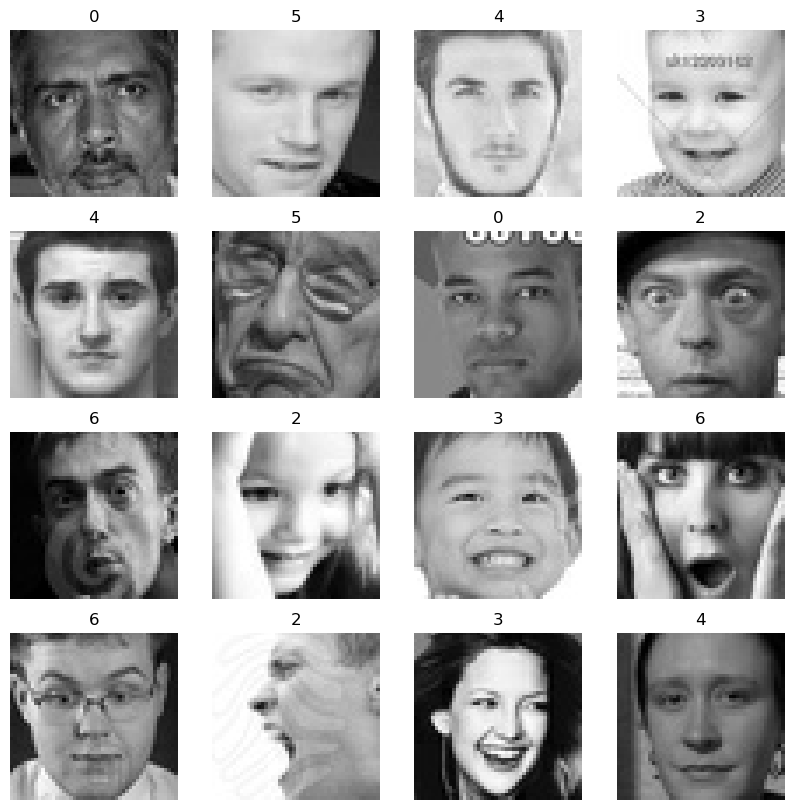

2024-07-07 22:04:35.519774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Show the first 16 images and their labels
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(np.argmax(labels[i]))
        plt.axis('off')
    plt.show()


Image shape: (64, 48, 48, 3), Label dtype: <dtype: 'float32'>
Image dtype: <dtype: 'float32'>, Label dtype: <dtype: 'float32'>


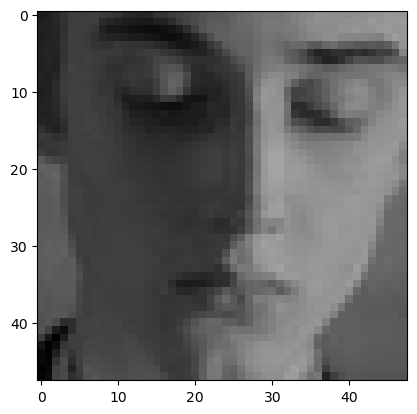

2024-07-07 22:04:48.897959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [60]:
# Print one image (to confirm whether the images are represented as 48x48x1 tensors)
for img, label in train_ds.take(1):
    print(f"Image shape: {img.shape}, Label dtype: {label.dtype}")
    print(f"Image dtype: {img.dtype}, Label dtype: {label.dtype}")
    
    # Plot the rgb image
    plt.imshow(img[0])
    plt.show()

## Dataset Visualization

In [ ]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch, label_lookup):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        # Show image as grayscale
        plt.imshow(tf.squeeze(image_batch[n]), cmap='gray')
        label = label_lookup.get_vocabulary()[tf.argmax(label_batch[n]).numpy()]
        plt.title(label)
        plt.axis("off")

# Eine Stichprobe aus dem Trainingsdatensatz anzeigen
for image_batch, label_batch in combined_train_ds.take(1):
    show_batch(image_batch, label_batch, label_lookup)

for image_batch, label_batch in test_ds.take(1):
    show_batch(image_batch, label_batch, label_lookup)

In [63]:
import collections

def get_class_distribution(dataset):
    class_counts = collections.Counter()
    
    for _, label_batch in dataset:
        labels = tf.argmax(label_batch, axis=1)
        class_counts.update(labels.numpy())
    
    return class_counts

# Klassenverteilung im Trainingsdatensatz
train_class_distribution = get_class_distribution(train_ds)
print("Train Class Distribution:", train_class_distribution)

# Klassenverteilung im Testdatensatz
test_class_distribution = get_class_distribution(test_ds)
print("Test Class Distribution:", test_class_distribution)


2024-07-07 22:05:34.184550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Class Distribution: Counter({3: 7215, 4: 4965, 5: 4830, 2: 4097, 0: 3995, 6: 3171, 1: 436})
Test Class Distribution: Counter({3: 1774, 5: 1247, 4: 1233, 2: 1024, 0: 958, 6: 831, 1: 111})


2024-07-07 22:05:35.498246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [64]:
import sklearn
from sklearn.utils import class_weight

# Load test data
x_train = []
y_train = []

for i, c in enumerate(classes):
    path = os.path.join(train_dir, c)
    for img_name in os.listdir(path):
        # img = cv2.imread(os.path.join(path, img_name))
        if img is not None:  # Ensure the image was read correctly
            # img = cv2.resize(img, (48, 48))
            # x_train.append(img)
            y_train.append(i)

{0, 1, 2, 3, 4, 5, 6}


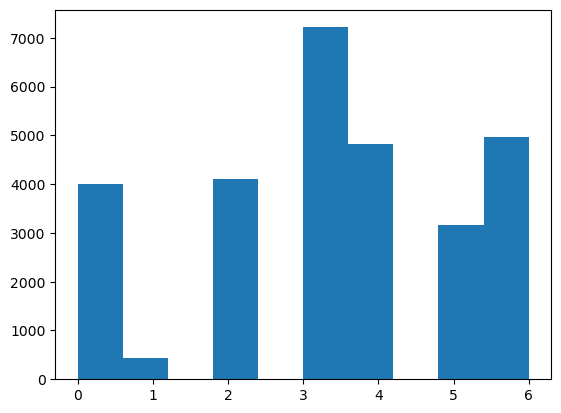

In [65]:
print(set(y_train))
plt.hist(y_train)
plt.show()

In [66]:
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7)

# Nehme an, y_train_labels sind die Labels deiner Trainingsdaten
y_train_labels = np.argmax(y_train_encoded, axis=1)
y_train_labels = y_train_labels.astype(np.int32)

# Berechnung der Klassengewichte
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train_labels),
                                                  y=y_train_labels)

# Convert the class weights to a dictionary. Use np.int32 as the key type
class_weights_dict = {int(k): float(v) for k, v in zip(np.unique(y_train_labels), class_weights)}

print("Class weights:", class_weights_dict)
# Print the type of keys in the dictionary
print("Type of keys:", type(list(class_weights_dict.keys())[0]))
# Print the type of values in the dictionary
print("Type of values:", type(list(class_weights_dict.values())[0]))

Class weights: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8491274770777877, 5: 1.293372978330405, 6: 0.8260394187886635}
Type of keys: <class 'int'>
Type of values: <class 'float'>


In [67]:
# Callback functions
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True, mode='max')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=20, min_lr=0.00001, mode='max')


In [69]:
for image, label in train_ds.take(1):  # Only take the first batch
    print(label[0])  # Show the label

tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)


2024-07-07 22:06:11.970282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Training & Evaluation

In [70]:
history = model.fit(
    train_ds,
    # class_weight=class_weights_dict,
    epochs=5000,
    validation_data=test_ds,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/5000
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2912 - loss: 1.8248

I0000 00:00:1720382893.679003   26322 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3303', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1720382893.715480   26348 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3303', 308 bytes spill stores, 308 bytes spill loads



449/449 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - accuracy: 0.2912 - loss: 1.8246 - val_accuracy: 0.3732 - val_loss: 1.5983 - learning_rate: 0.0010
Epoch 2/5000
449/449 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3584 - loss: 1.6323 - val_accuracy: 0.3936 - val_loss: 1.5687 - learning_rate: 0.0010
Epoch 3/5000
449/449 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3684 - loss: 1.6050 - val_accuracy: 0.4064 - val_loss: 1.5533 - learning_rate: 0.0010
Epoch 4/5000
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3762 - loss: 1.5879 - val_accuracy: 0.4076 - val_loss: 1.5401 - learning_rate: 0.0010
Epoch 5/5000
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3875 - loss: 1.5714 - val_accuracy: 0.4160 - val_loss: 1.5233 - learning_rate: 0.0010
Epoch 6/5000
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3899 - loss: 1.5658 - val_accuracy: 0.4207 - val_loss: 1.5210 - learning_rate: 0.0010
Epoch 7/5000
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.3935 - loss: 

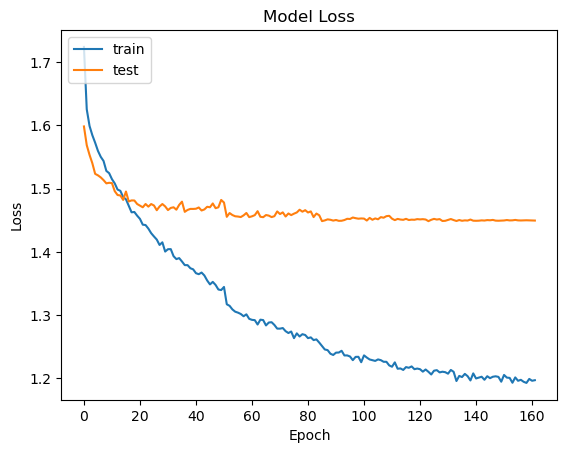

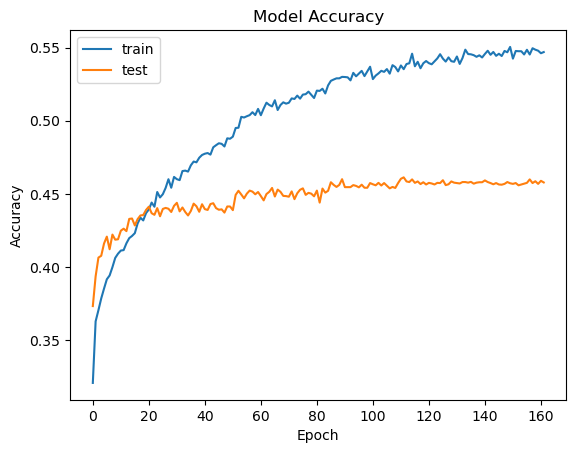

In [71]:
# Plot training history (loss and accuracy)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [72]:
# Fine-tuning
# Unfreeze the base model and train the entire model

for layer in base_model.layers:
    layer.trainable = True

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_ds,
    epochs=5000,
    validation_data=test_ds,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/5000


I0000 00:00:1720384228.352265   17687 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_slice_fusion_1', 104 bytes spill stores, 104 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_slice_fusion_2', 108 bytes spill stores, 108 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_slice_fusion', 72 bytes spill stores, 72 bytes spill loads



447/449 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2059 - loss: 2.8367

I0000 00:00:1720384273.918627   17687 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_slice_fusion_4', 104 bytes spill stores, 104 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_slice_fusion_3', 104 bytes spill stores, 104 bytes spill loads



449/449 ━━━━━━━━━━━━━━━━━━━━ 111s 116ms/step - accuracy: 0.2060 - loss: 2.8326 - val_accuracy: 0.2622 - val_loss: 1.7727 - learning_rate: 1.0000e-04
Epoch 2/5000
449/449 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.2897 - loss: 1.7497 - val_accuracy: 0.3727 - val_loss: 1.5617 - learning_rate: 1.0000e-04
Epoch 3/5000
449/449 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.3724 - loss: 1.5741 - val_accuracy: 0.4383 - val_loss: 1.3990 - learning_rate: 1.0000e-04
Epoch 4/5000
449/449 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.4380 - loss: 1.4316 - val_accuracy: 0.4955 - val_loss: 1.2912 - learning_rate: 1.0000e-04
Epoch 5/5000
449/449 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.4947 - loss: 1.3082 - val_accuracy: 0.4916 - val_loss: 1.2927 - learning_rate: 1.0000e-04
Epoch 6/5000
449/449 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.5443 - loss: 1.1870 - val_accuracy: 0.5238 - val_loss: 1.2329 - learning_rate: 1.0000e-04
Epoch 7/5000
449/449 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/

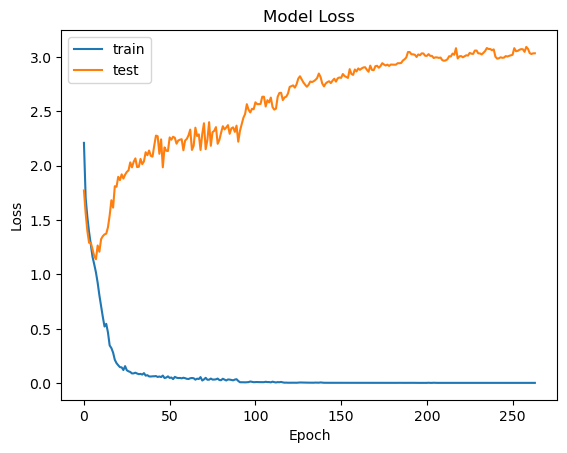

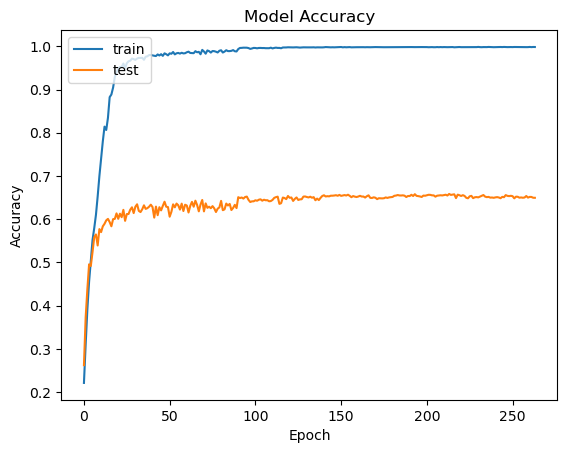

In [73]:
# Plot training history (loss and accuracy)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [76]:
# Load test data
x_test = []
y_test = []

for i, c in enumerate(classes):
    path = os.path.join(test_dir, c)
    for img_name in os.listdir(path):
        img = cv2.imread(os.path.join(path, img_name))
        if img is not None:  # Ensure the image was read correctly
            if greyscale:
                img = cv2.resize(img, (48, 48))
                # Image to greyscale and shape (48, 48, 1)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            x_test.append(img)
            y_test.append(i)

x_test = np.array(x_test)
y_test = np.array(y_test)

# Bruh, why you taking so long..

y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=7)


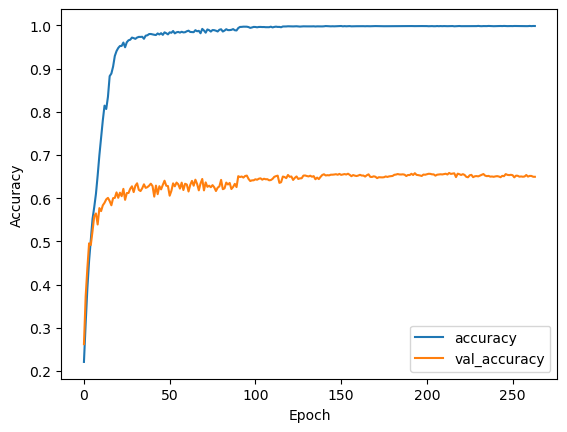

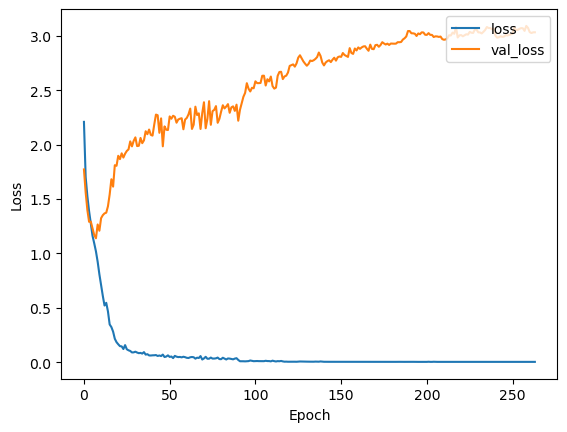

Training Accuracy: [0.2210804969072342, 0.310042142868042, 0.3916890025138855, 0.4551534354686737, 0.5046849250793457, 0.5517085194587708, 0.579226016998291, 0.6100874543190002, 0.6525828242301941, 0.699362576007843, 0.7391758561134338, 0.7800689935684204, 0.8142046332359314, 0.8064021468162537, 0.8345814943313599, 0.8824062347412109, 0.888467013835907, 0.904594361782074, 0.929046630859375, 0.9403671026229858, 0.9476122260093689, 0.9522101283073425, 0.9523494243621826, 0.9601518511772156, 0.9492493867874146, 0.9608833193778992, 0.9653767347335815, 0.9667003154754639, 0.9716465473175049, 0.9703925848007202, 0.9687206149101257, 0.9717510342597961, 0.9732487797737122, 0.9731791615486145, 0.9735274910926819, 0.9688947796821594, 0.9761050343513489, 0.9769758582115173, 0.9797973036766052, 0.9799714088439941, 0.9789612889289856, 0.9781601428985596, 0.9775331616401672, 0.9812602400779724, 0.9788219928741455, 0.9818175435066223, 0.9779163599014282, 0.9838029742240906, 0.9817478656768799, 0.9791

I0000 00:00:1720387958.496388   23386 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3304', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1720387958.794942   23376 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3304', 192 bytes spill stores, 192 bytes spill loads



225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.1678 - loss: 440.8975
[349.60162353515625, 0.2263861745595932]
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       958
           1       0.00      0.00      0.00       111
           2       0.00      0.00      0.00      1024
           3       0.24      0.58      0.34      1774
           4       0.21      0.48      0.29      1247
           5       0.00      0.00      0.00       831
           6       0.00      0.00      0.00      1233

    accuracy                           0.23      7178
   macro avg       0.21      0.15      0.09      7178
weighted avg       0.23      0.23      0.13      7178

Confusion Matrix:
 [[   1    0    0  568  389    0    0]
 [   0    0    0   82   29    0    0]
 [   0    0    0  670  354    0    0]
 [   0    0    0 1023  751    0    0]
 [   0    0    0  646  601    0    0]
 [   0  

/home/renlephy/miniconda3/envs/tf_gpu2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/renlephy/miniconda3/envs/tf_gpu2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/renlephy/miniconda3/envs/tf_gpu2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

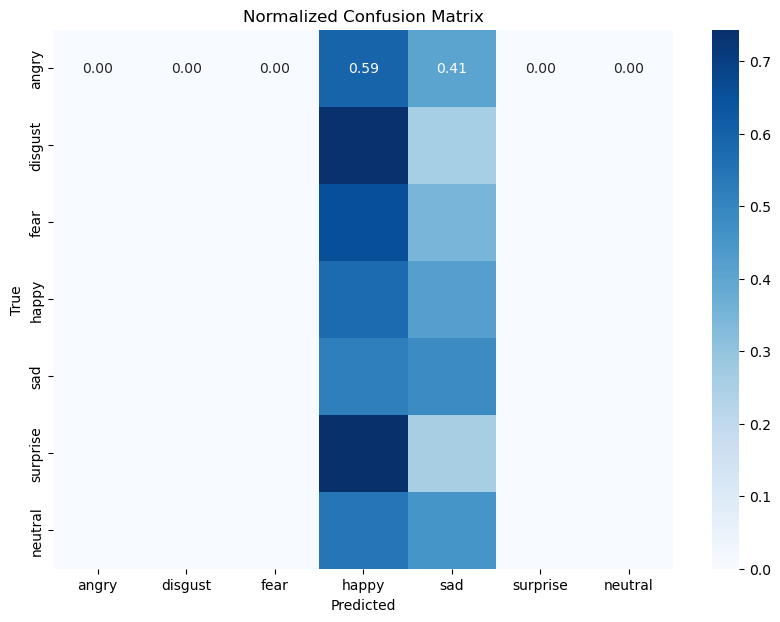

Image shape: (48, 48, 3)


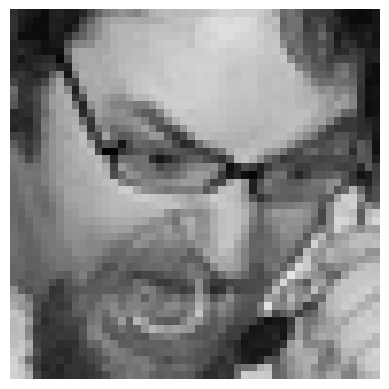

ValueError: cannot reshape array of size 6912 into shape (1,48,48,1)

In [77]:
if history is not None:

    # PLOT TRAINING AND VALIDATION ACCURACY
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

    # PLOT TRAINING AND VALIDATION LOSS
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()
    
    # Zugreifen auf die Metriken im Trainingsverlauf
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Beispielausgabe der Genauigkeit
    print("Training Accuracy:", accuracy)
    print("Validation Accuracy:", val_accuracy)


# SAVE MODEL, if model is defined

if model is not None: 
    model.save('emotion_recognition_model.h5')
    print('Model saved as emotion_recognition_model.h5')
else:
    # Load model
    model = tf.keras.models.load_model('emotion_recognition_model.h5')
    print('Model loaded from emotion_recognition_model.h5')

# Confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# Evaluate model
# Evaluiere das Modell
evaluation = model.evaluate(x_test, y_test_encoded)

# Evaluationsergebnisse anzeigen
print(evaluation)

# Predict test data
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print('Classification Report:\n', classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print("Confusion Matrix:\n", cm)
print("Normalized Confusion Matrix:\n", cm_normalized)

# Display normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# TEST MODEL
# Load test image
file_path = 'dataset/test/angry/PrivateTest_88305.jpg'
img = x_test[0]
print(f'Image shape: {img.shape}')

# Display image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

img = np.reshape(img, [1, 48, 48, 1])
img = img / 255.0  # Normalize to [0, 1]
# Predict emotion
prediction = model.predict(img)
emotion = classes[np.argmax(prediction)]
print(f'Predicted emotion: {emotion}')

# Display prediction
plt.bar(classes, prediction[0])
plt.ylabel('Probability')
plt.show()

# 5x5 matrix with random pictures from the test set, labeled with the predicted emotion and the true emotion; text color is green if the prediction is correct, red otherwise
import random

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    index = random.randint(0, len(x_test) - 1)
    img = x_test[index]
    img = np.reshape(img, [1, 48, 48, 1])
    img = img / 255.0  # Normalize to [0, 1]
    prediction = model.predict(img)
    emotion = classes[np.argmax(prediction)]
    true_emotion = classes[y_test[index]]
    color = 'g' if emotion == true_emotion else 'r'
    plt.imshow(cv2.cvtColor(x_test[index], cv2.COLOR_BGR2RGB))
    plt.title(f'Pred: {emotion}\nTrue: {true_emotion}', color=color)
    plt.axis('off')
    plt.tight_layout()
    
plt.show()